In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import minimize

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Setup problem

In [2]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)

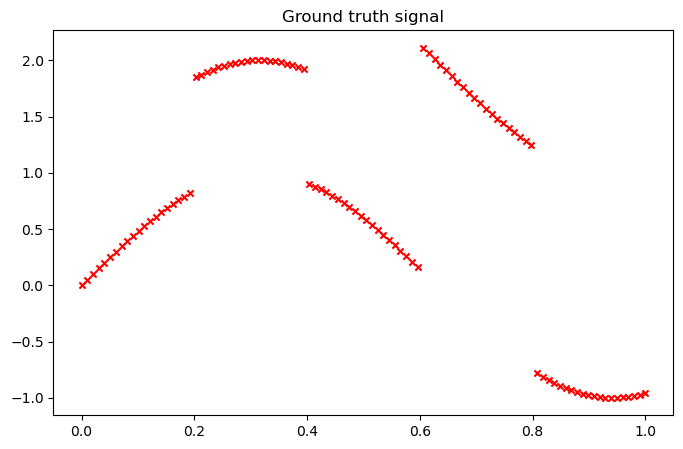

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [4]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [5]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

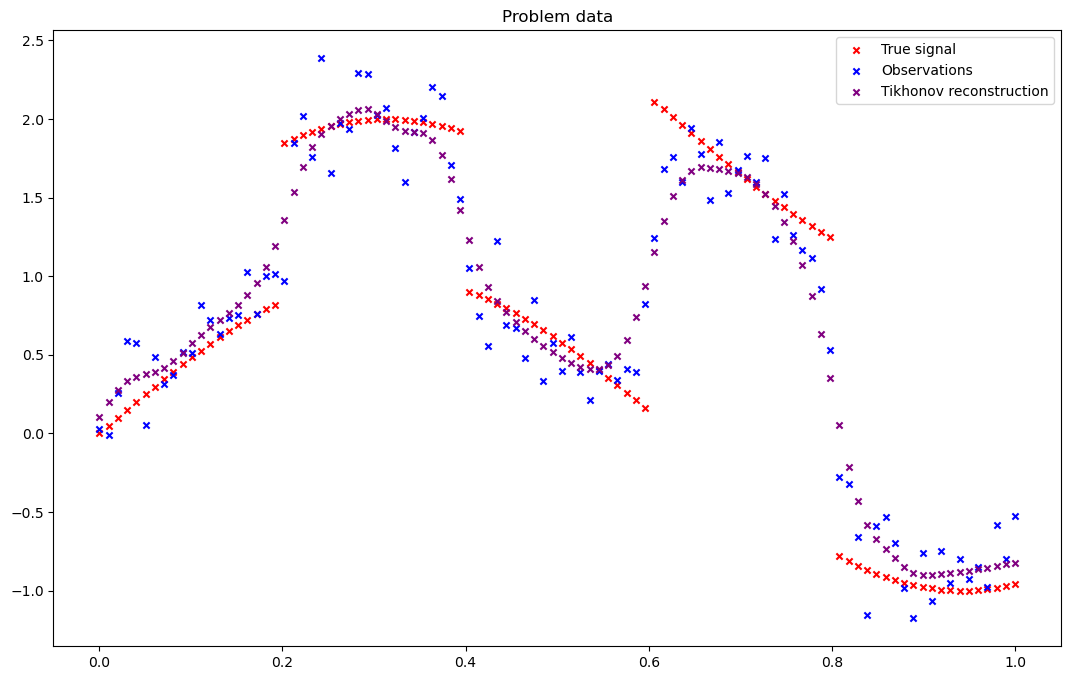

In [6]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

# ME method

In [29]:
from tracelogdetdiag.util import relative_resigual_cg, AinvCGLinearOperator
from tracelogdetdiag.trace import hutch_plus_plus_trace, hutchinson_trace

In [81]:
# Parameters
reg_lambda = 1e1
cg_tol = 1e-3
cg_maxits = int(1e6)
n_iterations = 20
uk = None
J = 30
A = F
T = R
#T = aslinearoperator(np.eye(100)) 
b = y
d = A.shape[1]

for k in range(n_iterations):
    
    # Make new H
    Hk = (A.T @ A) + reg_lambda*(T.T @ T)

    # Get current reconstruction
    uk = relative_resigual_cg(Hk, A.T @ b, x0=None, eps=cg_tol, maxits=cg_maxits)["x"]

    # Evaluate traces
    Hkinv = AinvCGLinearOperator(Hk, cg_tol=cg_tol, cg_maxits=cg_maxits)
    #T_trace = hutch_plus_plus_trace(Hkinv @ ( A.T @ A ), sample_size=6 )
    T_trace = hutchinson_trace(Hkinv @ ( T.T @ T ), sample_size=J)
    A_trace = hutchinson_trace(Hkinv @ ( A.T @ A ), sample_size=J)

    # # Improve trace estimate
    # denom_trace = A_trace + reg_lambda*T_trace
    # T_trace = d*T_trace/denom_trace
    # A_trace = d*A_trace/denom_trace

    # Compute new sigma and eta
    residual = (A @ uk) - b
    sigma_squared = (residual.T @ residual)/(A.shape[0])
    Tuk = T @ uk
    eta_squared = (Tuk.T @ Tuk)/( (T.shape[1]) - reg_lambda*T_trace) # Here, really need to involve the rank of T
    reg_lambda = sigma_squared/eta_squared  

    print(f"Iteration {k}") 
    print(f"noise_var: {sigma_squared}")
    print(f"eta_squared: {eta_squared}")
    print() 

Iteration 0
noise_var: 0.06599998298911451
eta_squared: 0.06924771027926085

Iteration 1
noise_var: 0.03286307955700042
eta_squared: 0.08746706849332464

Iteration 2
noise_var: 0.027476984527126536
eta_squared: 0.10829432902216675

Iteration 3
noise_var: 0.025764056974373874
eta_squared: 0.1242468084620907

Iteration 4
noise_var: 0.024975079600657802
eta_squared: 0.11870793920996997

Iteration 5
noise_var: 0.025029182252470285
eta_squared: 0.12436092545986643

Iteration 6
noise_var: 0.024864980282365848
eta_squared: 0.12967835775754985

Iteration 7
noise_var: 0.024690019919331806
eta_squared: 0.1346752847796955

Iteration 8
noise_var: 0.02453213391311532
eta_squared: 0.12157246064920059

Iteration 9
noise_var: 0.024874568740937332
eta_squared: 0.12699318489271963

Iteration 10
noise_var: 0.024766400328431016
eta_squared: 0.13289183765490684

Iteration 11
noise_var: 0.024589444570795652
eta_squared: 0.1296368749434339

Iteration 12
noise_var: 0.024651569699788486
eta_squared: 0.13463125

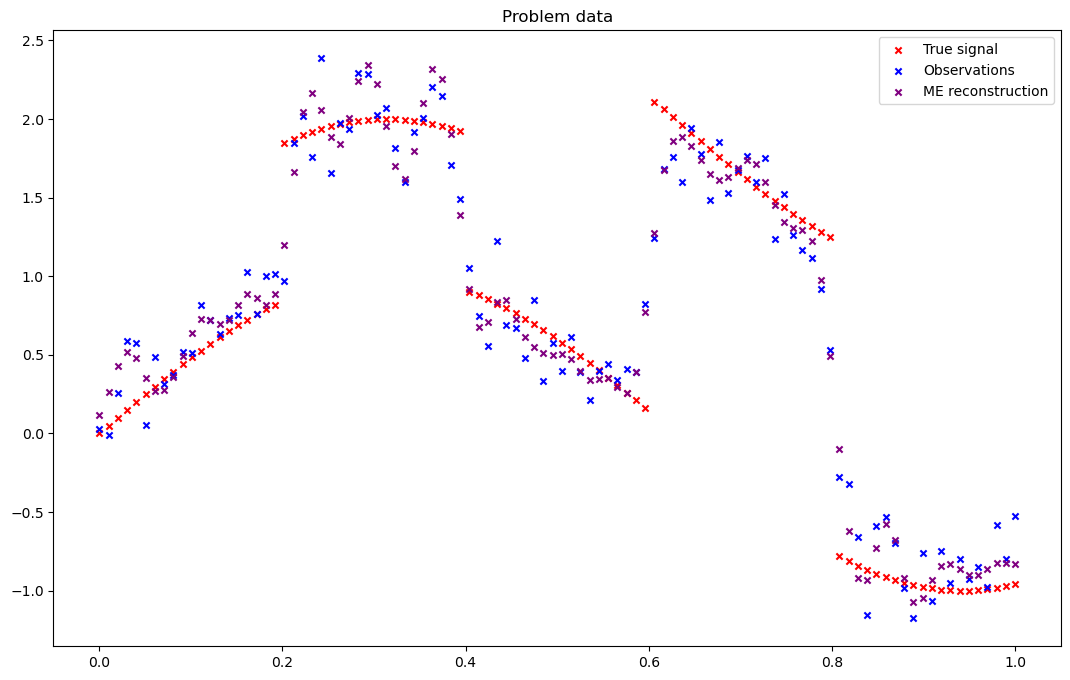

In [82]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
#plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.scatter(dom, uk, marker="x", color="purple", s=20.0, label="ME reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

In [78]:
noise_sigma**2

0.04000000000000001

# Final function

In [ ]:
def sanders_me_method(A, T, trace_samples=15, cg_eps=1e-2, cg_maxits=1000):
    """Implements the maximum expectation method in [9].
    """